In [15]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

df = pd.read_csv("1st-dataset-prepressed-baseball.csv")     # 1차 데이터셋

# df = df[df['sports_type'] == "야구"]        # 야구 데이타만 가져옴

pd.set_option("display.max_columns", None)

df['accident_score'] = df['accident_count'] + 3 * df['injury_count']

# 분석용 편의 함수
def pct(n): return f"{n:.1%}"

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# X-Columes
# x_cols = ['match_정규시즌', 'match_포스트시즌', 'is_holiday', 'start_hour', 'audience'] 

# 1. 독립 변수와 종속 변수 정의
# X = df[x_cols].astype(int)  # bool을 int로 변환
# y = df['accident_count']

# 1. 독립 변수와 종속 변수 정의
X = df.drop(columns=["accident_score", "accident_count", "injury_count", "death_count", "game_id", "stadium_code","sports_type","game_date", "day_of_week", "start_time", "region", "snow_depth"])
y = df['accident_score']

x_cols = X.columns

# 2. 학습용/테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
# 3. 선형회귀 모델 생성 및 학습
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 4. 예측
y_pred = model.predict(X_test_scaled)

# 5. 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 6. 결과 출력
print("회귀계수 (", x_cols, "):", model.coef_)
print("절편 (intercept):", model.intercept_)
print("평균제곱오차 (MSE):", mse)
print("결정계수 (R²):", r2)

회귀계수 ( Index(['is_holiday', 'home_team_win', 'audience', 'temperature',
       'precipitation', 'start_hour', 'match_시범경기', 'match_정규시즌',
       'match_포스트시즌'],
      dtype='object') ): [-1.35144019  0.63819926  3.35227672 -0.65325587 -1.25440878  1.49833035
 -0.65056033 -0.08631737  1.25977948]
절편 (intercept): 25.511164755582378
평균제곱오차 (MSE): 538.0528106172004
결정계수 (R²): 0.02236127678379618


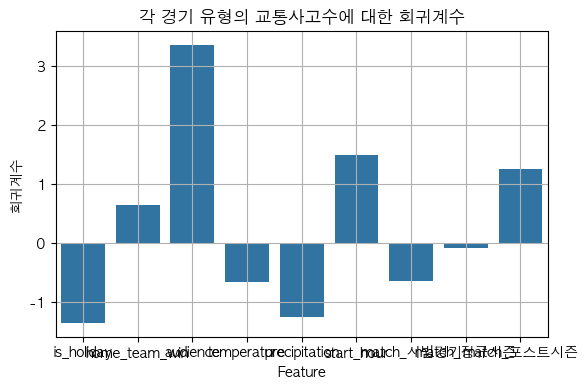

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# -------------------- 3-4. 범주형 ↔ 사고건수 -----------------
# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'

# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

# -------------------------------
# 📊 2. 회귀 계수 시각화
# -------------------------------
coef_df = pd.DataFrame({
    'Feature': x_cols,
    'Coefficient': model.coef_
})

plt.figure(figsize=(6, 4))
sns.barplot(x='Feature', y='Coefficient', data=coef_df)
plt.title('각 경기 유형의 교통사고수에 대한 회귀계수')
plt.ylabel("회귀계수")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
## 포이송 회기 변수 적요
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 변수 준비: bool → int 변환
df_model = df[['accident_count', 'match_정규시즌', 'match_포스트시즌', 'is_holiday', 'start_hour', 'audience']].copy()
df_model['match_정규시즌'] = df_model['match_정규시즌'].astype(int)
df_model['match_포스트시즌'] = df_model['match_포스트시즌'].astype(int)

# 포아송 회귀모델 정의 (GLM - Generalized Linear Model)
model = smf.glm(
    formula='accident_count ~ match_정규시즌 + match_포스트시즌 + is_holiday + start_hour + audience',
    data=df_model,
    family=sm.families.Poisson()
)

# 모델 학습
result = model.fit()

# 결과 출력
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_count   No. Observations:                 2072
Model:                            GLM   Df Residuals:                     2066
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7003.7
Date:                Wed, 04 Jun 2025   Deviance:                       8393.5
Time:                        12:50:33   Pearson chi2:                 7.95e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1487
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6007      0.150      4.012      